In [2]:
!unzip '/content/fatigue.zip' -d  '/content/fatigue'
!unzip  "/content/no fatigue.zip" -d '/content/no_fatigue'

Archive:  /content/fatigue.zip
  inflating: /content/fatigue/fatigue/111_cropped.png  
  inflating: /content/fatigue/fatigue/112_cropped.png  
  inflating: /content/fatigue/fatigue/115_cropped.png  
  inflating: /content/fatigue/fatigue/119_cropped.png  
  inflating: /content/fatigue/fatigue/120_cropped.png  
  inflating: /content/fatigue/fatigue/127_cropped.png  
  inflating: /content/fatigue/fatigue/128_cropped.png  
  inflating: /content/fatigue/fatigue/129_cropped.png  
  inflating: /content/fatigue/fatigue/130_cropped.png  
  inflating: /content/fatigue/fatigue/132_cropped.png  
  inflating: /content/fatigue/fatigue/133_cropped.png  
  inflating: /content/fatigue/fatigue/134_cropped.png  
  inflating: /content/fatigue/fatigue/135_cropped.png  
  inflating: /content/fatigue/fatigue/136_cropped.png  
  inflating: /content/fatigue/fatigue/137_cropped.png  
  inflating: /content/fatigue/fatigue/138_cropped.png  
  inflating: /content/fatigue/fatigue/139_cropped.png  
  inflating: /con

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import os

Image Data preparation and Visiualization

In [29]:
# Image Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Dataset Loading
dataset = datasets.ImageFolder(root='/content/data', transform=transform)
# Assuming folder structure: data/fatigue and data/not_fatigue
labels = [sample[1] for sample in dataset.imgs]

# Train-Test Split with Stratify
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
from collections import Counter

# Extract labels for training and validation datasets
train_labels = [dataset.targets[i] for i in train_idx]
val_labels = [dataset.targets[i] for i in val_idx]

# Count the occurrences of each class in training and validation datasets
train_class_counts = Counter(train_labels)
val_class_counts = Counter(val_labels)

# Map class indices to class names
class_names = dataset.classes

# Print class distribution in the training set
print("Training Set Class Distribution:")
for idx, count in train_class_counts.items():
    print(f"Class '{class_names[idx]}': {count} samples")

# Print class distribution in the validation set
print("\nValidation Set Class Distribution:")
for idx, count in val_class_counts.items():
    print(f"Class '{class_names[idx]}': {count} samples")

Training Set Class Distribution:
Class 'no_fatigue': 81 samples
Class 'fatigue': 69 samples

Validation Set Class Distribution:
Class 'no_fatigue': 20 samples
Class 'fatigue': 18 samples


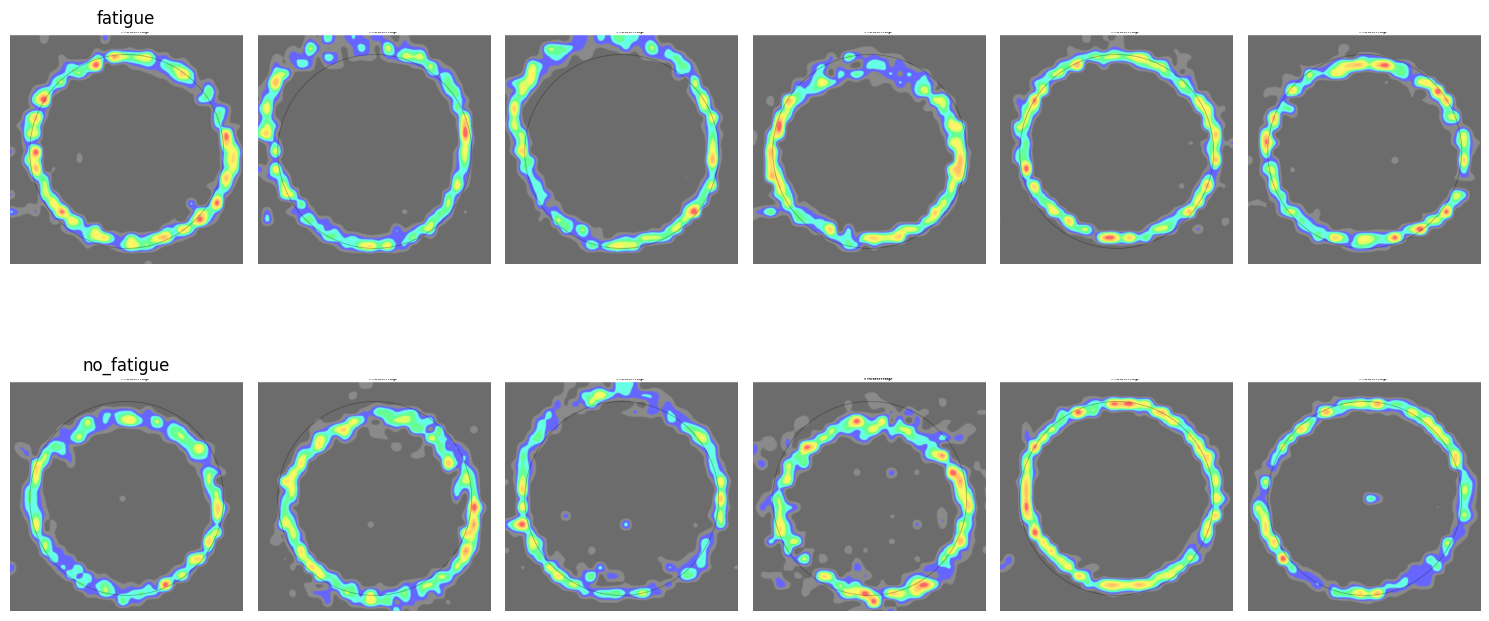

In [ ]:
# Display 6 Random Images per Class
def show_random_images(dataset, class_names):
    fig, axes = plt.subplots(len(class_names), 6, figsize=(15, 8))
    for class_idx, class_name in enumerate(class_names):
        class_samples = [img_path for img_path, label in dataset.samples if label == class_idx]
        random_samples = random.sample(class_samples, 6)
        for img_idx, img_path in enumerate(random_samples):
            image = plt.imread(img_path)
            axes[class_idx, img_idx].imshow(image)
            axes[class_idx, img_idx].axis('off')
            if img_idx == 0:
                axes[class_idx, img_idx].set_title(class_name)
    plt.tight_layout()
    plt.show()

# Show Random Images per Class
show_random_images(dataset, class_names)

Image data


Training GoogLeNet...
GoogLeNet - Epoch [1/10], Loss: 0.7246, Val Accuracy: 52.63%
GoogLeNet - Epoch [2/10], Loss: 0.6880, Val Accuracy: 44.74%
GoogLeNet - Epoch [3/10], Loss: 0.5696, Val Accuracy: 52.63%
GoogLeNet - Epoch [4/10], Loss: 0.5660, Val Accuracy: 57.89%
GoogLeNet - Epoch [5/10], Loss: 0.4428, Val Accuracy: 47.37%
GoogLeNet - Epoch [6/10], Loss: 0.3157, Val Accuracy: 57.89%
GoogLeNet - Epoch [7/10], Loss: 0.3789, Val Accuracy: 57.89%
GoogLeNet - Epoch [8/10], Loss: 0.3351, Val Accuracy: 57.89%
GoogLeNet - Epoch [9/10], Loss: 0.3179, Val Accuracy: 68.42%
GoogLeNet - Epoch [10/10], Loss: 0.2352, Val Accuracy: 57.89%

Training ResNet18...
ResNet18 - Epoch [1/10], Loss: 0.8638, Val Accuracy: 50.00%
ResNet18 - Epoch [2/10], Loss: 0.9766, Val Accuracy: 57.89%
ResNet18 - Epoch [3/10], Loss: 0.6484, Val Accuracy: 44.74%
ResNet18 - Epoch [4/10], Loss: 0.6037, Val Accuracy: 50.00%
ResNet18 - Epoch [5/10], Loss: 0.5308, Val Accuracy: 60.53%
ResNet18 - Epoch [6/10], Loss: 0.4630, Val A

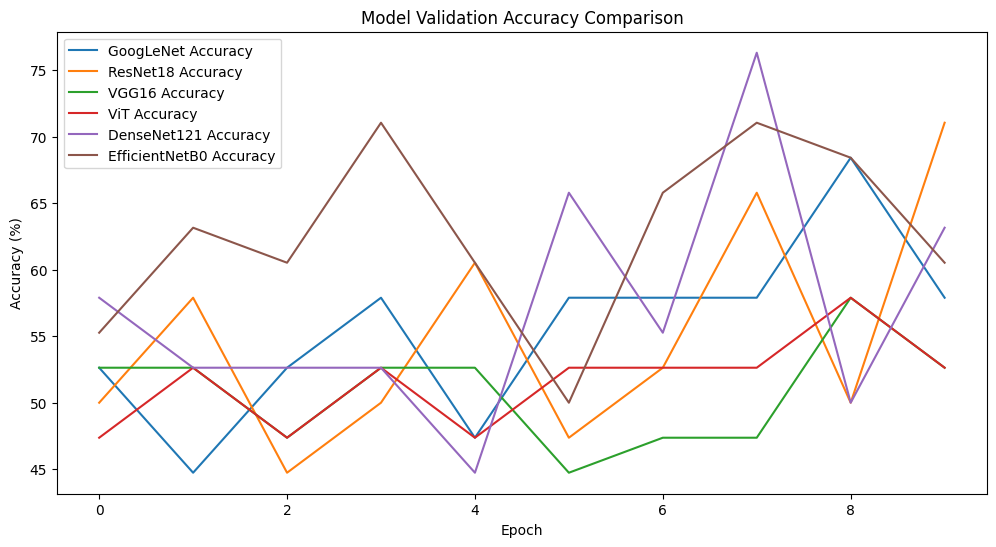

In [ ]:
# Model Definitions
class CustomModel(nn.Module):
    def __init__(self, base_model, model_name):
        super(CustomModel, self).__init__()
        self.base_model = base_model
        if model_name in ['ResNet18', 'GoogLeNet']:
            self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1)
        elif model_name == 'VGG16':
            self.base_model.classifier[6] = nn.Linear(self.base_model.classifier[6].in_features, 1)
        elif model_name == 'DenseNet121':
            self.base_model.classifier = nn.Linear(self.base_model.classifier.in_features, 1)
        elif model_name == 'EfficientNetB0':
            self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, 1)
        elif model_name == 'ViT':
            self.base_model.heads.head = nn.Linear(self.base_model.heads.head.in_features, 1)

    def forward(self, x):
        x = self.base_model(x)
        return torch.sigmoid(x)

# Initialize Models
models_dict = {
    'GoogLeNet': CustomModel(models.googlenet(pretrained=True), 'GoogLeNet'),
    'ResNet18': CustomModel(models.resnet18(pretrained=True), 'ResNet18'),
    'VGG16': CustomModel(models.vgg16(pretrained=True), 'VGG16'),
    'ViT': CustomModel(models.vit_b_16(pretrained=True), 'ViT'),
    'DenseNet121': CustomModel(models.densenet121(pretrained=True), 'DenseNet121'),
    'EfficientNetB0': CustomModel(models.efficientnet_b0(pretrained=True), 'EfficientNetB0')
}

# Training Function
def train_model(model, model_name, num_epochs=10):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_accuracies = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)
            labels = labels.view(-1, 1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted.view(-1) == labels).sum().item()

        accuracy = 100 * correct / total
        val_accuracies.append(accuracy)
        print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Accuracy: {accuracy:.2f}%')
    torch.save(model.state_dict(), f'{model_name}_binary_classification.pth')
    return train_losses, val_accuracies

# Training All Models
results = {}
for name, model in models_dict.items():
    print(f'\nTraining {name}...')
    losses, accuracies = train_model(model, name)
    results[name] = {'Loss': losses, 'Accuracy': accuracies}

# Plot Comparison
plt.figure(figsize=(12, 6))
for name in results:
    plt.plot(results[name]['Accuracy'], label=f'{name} Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model Validation Accuracy Comparison')
plt.legend()
plt.show()

Image with Tabulare data

In [78]:
df = pd.read_excel('/content/fatigue levels.xlsx')
df.head()

,list of trials,image name,fatigue level,mental fatigue,class (0-1)=0 (no fatigue); (2-3)=1 (fatigue),RT,Entropy
0,1001_0,29_cropped,2,1,0,0.4033,18.994072
1,1001_1,30_cropped,2,1,0,0.3742,18.721839
2,1001_2,31_cropped,2,1,0,0.3688,18.760150
3,1001_3,32_cropped,2,0,0,0.3981,18.759705
4,1001_4,33_cropped,1,0,0,0.4646,18.920669


Prepare dataframe

In [79]:
import tqdm
import os

for idx, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    df.at[idx, 'image name'] = os.path.join('/content/image_data', row['image name']) + '.png'

df.head()

100%|██████████| 188/188 [00:00<00:00, 7831.02it/s]


,list of trials,image name,fatigue level,mental fatigue,class (0-1)=0 (no fatigue); (2-3)=1 (fatigue),RT,Entropy
0,1001_0,/content/image_data/29_cropped.png,2,1,0,0.4033,18.994072
1,1001_1,/content/image_data/30_cropped.png,2,1,0,0.3742,18.721839
2,1001_2,/content/image_data/31_cropped.png,2,1,0,0.3688,18.760150
3,1001_3,/content/image_data/32_cropped.png,2,0,0,0.3981,18.759705
4,1001_4,/content/image_data/33_cropped.png,1,0,0,0.4646,18.920669


In [80]:
df.tail()

,list of trials,image name,fatigue level,mental fatigue,class (0-1)=0 (no fatigue); (2-3)=1 (fatigue),RT,Entropy
183,Ahmad_trial_1,/content/image_data/1_cropped.png,2,2,1,0.5664,18.189728
184,Ahmad_trial_2,/content/image_data/2_cropped.png,2,2,1,0.5150,18.286257
185,Ahmad_trial_3,/content/image_data/3_cropped.png,2,2,1,0.5259,18.136463
186,Ahmad_trial_4,/content/image_data/4_cropped.png,2,2,1,0.5095,18.316950
187,Ahmad_trial_5,/content/image_data/5_cropped.png,2,2,1,0.5094,18.170609


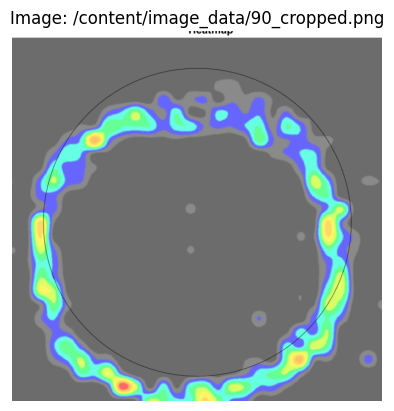

In [81]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Randomly select an image name
random_idx = random.choice(df.index)
image_name = df.at[random_idx, 'image name']

# Load the image
img = Image.open(image_name)

# Plot the image
plt.imshow(img)
plt.title(f"Image: {image_name}")
plt.axis('off')  # Hide axes
plt.show()

Based on Image RT and Image

In [67]:
# Custom Dataset
class FatigueDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image name']
        rt = self.data.iloc[idx]['RT']
        label = self.data.iloc[idx]['class (0-1)=0 (no fatigue); (2-3)=1 (fatigue)']

        # Load Image
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(rt, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [68]:
# Image Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Dataset and Split
dataset = FatigueDataset(df, transform=transform)
train_idx, val_idx = train_test_split(range(len(dataset)), test_size=0.2, stratify=df['class (0-1)=0 (no fatigue); (2-3)=1 (fatigue)'], random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Modified Model
class CustomModel(nn.Module):
    def __init__(self, base_model):
        super(CustomModel, self).__init__()
        self.base_model = base_model
        self.base_model.fc = nn.Linear(base_model.fc.in_features, 128)
        self.fc_image = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.fc_combined = nn.Sequential(
            nn.Linear(64 + 1, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, image, rt):
        image_features = self.base_model(image)
        image_features = self.fc_image(image_features)
        combined = torch.cat((image_features, rt.unsqueeze(1)), dim=1)
        output = self.fc_combined(combined)
        return output

# Initialize Model
base_model = models.resnet18(pretrained=True)
model = CustomModel(base_model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
# Training Function
def train_model(model, num_epochs=10):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, rts, labels in train_loader:
            images, rts, labels = images.to(device), rts.to(device), labels.to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(images, rts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, rts, labels in val_loader:
                images, rts, labels = images.to(device), rts.to(device), labels.to(device).view(-1, 1)
                outputs = model(images, rts)
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

# Train Model
train_model(model)

Epoch [1/10], Loss: 0.6077
Validation Accuracy: 50.00%
Epoch [2/10], Loss: 0.3542
Validation Accuracy: 57.89%
Epoch [3/10], Loss: 0.1321
Validation Accuracy: 68.42%
Epoch [4/10], Loss: 0.0969
Validation Accuracy: 84.21%
Epoch [5/10], Loss: 0.0680
Validation Accuracy: 73.68%
Epoch [6/10], Loss: 0.1524
Validation Accuracy: 73.68%
Epoch [7/10], Loss: 0.0569
Validation Accuracy: 86.84%
Epoch [8/10], Loss: 0.0711
Validation Accuracy: 68.42%
Epoch [9/10], Loss: 0.1571
Validation Accuracy: 78.95%
Epoch [10/10], Loss: 0.1626
Validation Accuracy: 76.32%


Image and RT and Entropy

In [59]:
# Custom Dataset
class FatigueDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image name']
        rt = self.data.iloc[idx]['RT']
        entropy = self.data.iloc[idx]['Entropy']
        label = self.data.iloc[idx]['class (0-1)=0 (no fatigue); (2-3)=1 (fatigue)']

        # Load Image
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return (
            image,
            torch.tensor([rt, entropy], dtype=torch.float32),  # RT and Entropy as a tensor
            torch.tensor(label, dtype=torch.float32)
        )

In [64]:
# Image Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Dataset and Split
dataset = FatigueDataset(df, transform=transform)
train_idx, val_idx = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=df['class (0-1)=0 (no fatigue); (2-3)=1 (fatigue)'],
    random_state=42
)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [65]:
# Modified Model
class CustomModel(nn.Module):
    def __init__(self, base_model):
        super(CustomModel, self).__init__()
        self.base_model = base_model
        self.base_model.fc = nn.Linear(base_model.fc.in_features, 128)
        self.fc_image = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.fc_combined = nn.Sequential(
            nn.Linear(64 + 2, 32),  # Combine image features with RT and Entropy (2 additional inputs)
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, image, extra_features):
        image_features = self.base_model(image)
        image_features = self.fc_image(image_features)
        combined = torch.cat((image_features, extra_features), dim=1)
        output = self.fc_combined(combined)
        return output


In [66]:
# Initialize Model
base_model = models.resnet18(pretrained=True)
model = CustomModel(base_model)

# Training Function
def train_model(model, num_epochs=10):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, extra_features, labels in train_loader:
            images, extra_features, labels = (
                images.to(device),
                extra_features.to(device),
                labels.to(device).view(-1, 1)
            )

            optimizer.zero_grad()
            outputs = model(images, extra_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, extra_features, labels in val_loader:
                images, extra_features, labels = (
                    images.to(device),
                    extra_features.to(device),
                    labels.to(device).view(-1, 1)
                )
                outputs = model(images, extra_features)
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

# Train Model
train_model(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.6381
Validation Accuracy: 76.32%
Epoch [2/10], Loss: 0.3987
Validation Accuracy: 57.89%
Epoch [3/10], Loss: 0.1316
Validation Accuracy: 57.89%
Epoch [4/10], Loss: 0.1115
Validation Accuracy: 76.32%
Epoch [5/10], Loss: 0.0910
Validation Accuracy: 65.79%
Epoch [6/10], Loss: 0.1398
Validation Accuracy: 63.16%
Epoch [7/10], Loss: 0.2232
Validation Accuracy: 68.42%
Epoch [8/10], Loss: 0.2140
Validation Accuracy: 65.79%
Epoch [9/10], Loss: 0.1476
Validation Accuracy: 73.68%
Epoch [10/10], Loss: 0.0489
Validation Accuracy: 71.05%


Just Based on RT and Entropy

In [72]:
# Custom Dataset
class RTEntropyDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        rt = self.data.iloc[idx]['RT']
        entropy = self.data.iloc[idx]['Entropy']
        label = self.data.iloc[idx]['class (0-1)=0 (no fatigue); (2-3)=1 (fatigue)']
        return torch.tensor([rt, entropy], dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# Create Dataset and Split
dataset = RTEntropyDataset(df)
train_idx, val_idx = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=df['class (0-1)=0 (no fatigue); (2-3)=1 (fatigue)'],
    random_state=42
)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Simple Model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 16),  # 2 inputs: RT and Entropy
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Initialize Model
model = SimpleModel()

# Training Function
def train_model(model, num_epochs=10):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device).view(-1, 1)
                outputs = model(features)
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

# Train Model
train_model(model)

Epoch [1/10], Loss: 0.9190
Validation Accuracy: 47.37%
Epoch [2/10], Loss: 0.8563
Validation Accuracy: 47.37%
Epoch [3/10], Loss: 0.7930
Validation Accuracy: 47.37%
Epoch [4/10], Loss: 0.7519
Validation Accuracy: 47.37%
Epoch [5/10], Loss: 0.7258
Validation Accuracy: 47.37%
Epoch [6/10], Loss: 0.7085
Validation Accuracy: 47.37%
Epoch [7/10], Loss: 0.6983
Validation Accuracy: 47.37%
Epoch [8/10], Loss: 0.6921
Validation Accuracy: 52.63%
Epoch [9/10], Loss: 0.6916
Validation Accuracy: 52.63%
Epoch [10/10], Loss: 0.6902
Validation Accuracy: 52.63%


SVM

In [82]:
import pandas as pd
import torch
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Validation Accuracy: 0.68

Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.85      0.74        20
         1.0       0.75      0.50      0.60        18

    accuracy                           0.68        38
   macro avg       0.70      0.68      0.67        38
weighted avg       0.70      0.68      0.67        38



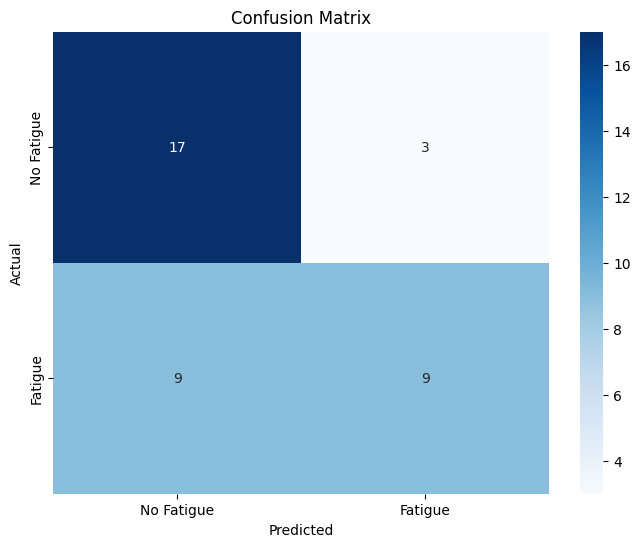

In [83]:
# Custom Dataset
class RTEntropyDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        rt = self.data.iloc[idx]['RT']
        entropy = self.data.iloc[idx]['Entropy']
        label = self.data.iloc[idx]['class (0-1)=0 (no fatigue); (2-3)=1 (fatigue)']
        return torch.tensor([rt, entropy], dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# Create Dataset and Split
dataset = RTEntropyDataset(df)
features = np.array([dataset[i][0].numpy() for i in range(len(dataset))])
labels = np.array([dataset[i][1].item() for i in range(len(dataset))])

X_train, X_val, y_train, y_val = train_test_split(
    features,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Scale Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Initialize and Train SVM
svm_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Validation
y_pred = svm_model.predict(X_val)

# Evaluation
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_report(y_val, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fatigue', 'Fatigue'], yticklabels=['No Fatigue', 'Fatigue'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()